In [7]:
import math

import gensim
from tqdm import tqdm

from UMLS import UMLSMapper, UMLSEvaluator
from evaluation_resource import NDFEvaluator, SRSEvaluator
from embeddings import Embeddings
from evaluate_embeddings import Evaluation

from vectorize_data import lines_from_file, preprocess

# General

In [2]:
embedding_name = "no_prep_vecs_test_all"
umls_mapper = UMLSMapper(json_path="E:/AML4DH-DATA/UMLS/mapper.json")

initialize UMLSMapper... Load json


# Vectorization

In [3]:
cpq_sentences = lines_from_file(path="E:/AML4DH-DATA/CPG-AMIA2020/Plain Text/cpg-sentences.txt")
print(cpq_sentences[:2])

['Helicobacter pylori ist der wesentliche Risikofaktor für das Magenkarzinom.', 'Die H. pylori-Eradikation mit dem Ziel der Magenkarzinomprävention sollte bei den folgenden Risikopersonen durchgeführt werden (siehe Tabelle unten).']


In [4]:
# tokenization
cpq_sentences = [sentence.split() for sentence in cpq_sentences]
print(cpq_sentences[:2])

[['Helicobacter', 'pylori', 'ist', 'der', 'wesentliche', 'Risikofaktor', 'für', 'das', 'Magenkarzinom.'], ['Die', 'H.', 'pylori-Eradikation', 'mit', 'dem', 'Ziel', 'der', 'Magenkarzinomprävention', 'sollte', 'bei', 'den', 'folgenden', 'Risikopersonen', 'durchgeführt', 'werden', '(siehe', 'Tabelle', 'unten).']]


In [5]:
# cpq_sentences = umls_mapper.standardize_documents(cpq_sentences)
cpq_sentences = umls_mapper.replace_documents_with_umls(cpq_sentences)
# cpq_sentences = preprocess(documents=cpq_sentences, lemmatize=True, remove_stopwords=True)
print(cpq_sentences[:2])

[['C0085508', 'pylori', 'ist', 'der', 'wesentliche', 'Risikofaktor', 'für', 'das', 'Magenkarzinom.'], ['Die', 'H.', 'pylori-Eradikation', 'mit', 'dem', 'Ziel', 'der', 'Magenkarzinomprävention', 'sollte', 'bei', 'den', 'folgenden', 'Risikopersonen', 'durchgeführt', 'werden', '(siehe', 'Tabelle', 'unten).']]


In [6]:
vecs = Embeddings.calculate_vectors(cpq_sentences, use_phrases=False)
Embeddings.save_medical(vecs, embedding_name, umls_mapper)

 ... (more hidden) ...


# Benchmarks

In [5]:
vecs = Embeddings.load(path=f"data/{embedding_name}.kv")
umls_evaluator = UMLSEvaluator(json_path="E:/AML4DH-DATA/UMLS/umls_eval.json")
ndf_evaluator = NDFEvaluator(json_path="E:/AML4DH-DATA/NDF/ndf_eval.json")
srs_evaluator = SRSEvaluator(json_path="E:/AML4DH-DATA/SRS/eval.json")

load embedding...
initialize UMLSEvaluator... Load json
initialize NDFEvaluator... Load json
initialize SRSEvaluator... Load json


In [6]:
for c, v in vecs.most_similar(umls_mapper.umls_dict["Cisplatin"]):
    print(umls_mapper.un_umls(c), v)
concept_vecs = umls_mapper.get_umls_vectors_only(vecs)

Carboplatin 0.8703843355178833
Paclitaxel 0.8661205768585205
Etoposid 0.8592477440834045
Docetaxel 0.8568588495254517
Capecitabin 0.8505868911743164
Oxaliplatin 0.8471230268478394
Gemcitabin 0.8366334438323975
Rituximab 0.8007310628890991
Cyclophosphamid 0.7927492260932922
Bendamustin 0.7917323708534241


In [8]:
evaluation = Evaluation(vecs, umls_mapper, umls_evaluator, ndf_evaluator, srs_evaluator)
evaluation.evaluate()

HumanAssessmentBenchmark
found 148 assessments in embeddings
HumanAssessment.SIMILARITY_CONT: 0.2506780830969652
found 46 assessments in embeddings
HumanAssessment.RELATEDNESS: 0.27215471067555175
found 142 assessments in embeddings
HumanAssessment.RELATEDNESS_CONT: 0.29959897313819794


# Experimental

In [ ]:
import math
from typing import Tuple

import gensim
from tqdm import tqdm

from UMLS import UMLSMapper, UMLSEvaluator
from embeddings import Embeddings
class Benchmark:
    def __init__(self, embeddings: gensim.models.KeyedVectors, umls_mapper: UMLSMapper, umls_evaluator: UMLSEvaluator):
        self.embeddings = embeddings
        self.umls_mapper = umls_mapper
        self.umls_evaluator = umls_evaluator

    def cosine(self, word1=None, word2=None, c1=None, c2=None):
        if word1:
            return self.embeddings.similarity(self.umls_mapper.umls_dict[word1], self.umls_mapper.umls_dict[word2])
        else:
            return self.embeddings.similarity(c1, c2)

    def pairwise_cosine(self, concepts1, concepts2=None):
        if concepts2 is None:
            concepts2 = concepts1
            s = 0
            count = -1
            for i, concept1 in enumerate(concepts1):
                for j, concept2 in enumerate(concepts2):
                    if j > i:
                        c = self.cosine(c1=concept1, c2=concept2)
                        if c < 0:
                            c = -c
                        s += c
                        count += 1

            return s / count
        else:
            s = 0
            count = 0
            for i, concept1 in enumerate(concepts1):
                for j, concept2 in enumerate(concepts2):
                    c = self.cosine(c1=concept1, c2=concept2)
                    if c < 0:
                        c = -c
                    s += c
                    count += 1
            return s / count

    def silhouette(self, term, category):
        def mean_between_distance(datapoint, same_cluster):
            sigma_ai = 0
            for reference_point in same_cluster:
                if datapoint == reference_point:
                    continue
                sigma_ai += self.cosine(c1=datapoint, c2=reference_point)

            return sigma_ai / (len(same_cluster)-1)

        def smallest_mean_out_distance(datapoint, other_clusters):
            distances = []
            for other_cluster in other_clusters:
                sigma_bi = 0
                for other_reference_point in other_cluster:
                    sigma_bi += self.cosine(c1=datapoint, c2=other_reference_point)
                sigma_bi = sigma_bi / len(other_cluster)
                distances.append(sigma_bi)
            return min(distances)

        cluster_name = category
        cluster = self.umls_evaluator.category2concepts[cluster_name]
        other_cluster_names = set(self.umls_evaluator.category2concepts.keys()).difference(cluster_name)
        other_clusters = [self.umls_evaluator.category2concepts[category] for category in other_cluster_names]

        a_i = mean_between_distance(term, cluster)
        b_i = smallest_mean_out_distance(term, other_clusters)
        print(a_i, b

In [11]:
import math
from typing import Tuple

import gensim
from tqdm import tqdm

from UMLS import UMLSMapper, UMLSEvaluator
from embeddings import Embeddings
class Benchmark:
    def __init__(self, embeddings: gensim.models.KeyedVectors, umls_mapper: UMLSMapper, umls_evaluator: UMLSEvaluator):
        self.embeddings = embeddings
        self.umls_mapper = umls_mapper
        self.umls_evaluator = umls_evaluator

    def cosine(self, word1=None, word2=None, c1=None, c2=None):
    
        if word1:
            cos = self.embeddings.similarity(self.umls_mapper.umls_dict[word1], self.umls_mapper.umls_dict[word2])
        else:
            cos = self.embeddings.similarity(c1, c2)
        if cos < 0:
            return -cos
        else:
            return cos

    def pairwise_cosine(self, concepts1, concepts2=None):
        if concepts2 is None:
            concepts2 = concepts1
            s = 0
            count = 0
            for i, concept1 in enumerate(concepts1):
                for j, concept2 in enumerate(concepts2):
                    if j > i:
                        c = self.cosine(c1=concept1, c2=concept2)
                        if c < 0:
                            c = -c
                        s += c
                        count += 1

            return s / count
        else:
            s = 0
            count = 0
            for i, concept1 in enumerate(concepts1):
                for j, concept2 in enumerate(concepts2):
                    c = self.cosine(c1=concept1, c2=concept2)
                    if c < 0:
                        c = -c
                    s += c
                    count += 1
            return s / count

    def silhouette(self, term, category):
        def mean_between_distance(datapoint, same_cluster):
            sigma_ai = 0
            for reference_point in same_cluster:
                if datapoint == reference_point:
                    continue
                sigma_ai += self.cosine(c1=datapoint, c2=reference_point)

            return sigma_ai / (len(same_cluster)-1)

        def smallest_mean_out_distance(datapoint, other_clusters):
            distances = []
            for other_cluster in other_clusters:
                sigma_bi = 0
                for other_reference_point in other_cluster:
                    sigma_bi += self.cosine(c1=datapoint, c2=other_reference_point)
                sigma_bi = sigma_bi / len(other_cluster)
                distances.append(sigma_bi)
            return sum(distances)/len(distances)
#             return min(distances)

        
        cluster = self.umls_evaluator.category2concepts[category]
        other_cluster_names = set(self.umls_evaluator.category2concepts.keys()).difference(category)
        other_clusters = [self.umls_evaluator.category2concepts[category] for category in other_cluster_names]

        a_i = mean_between_distance(term, cluster)
        b_i = smallest_mean_out_distance(term, other_clusters)
        
        if a_i < b_i:
            s_i = 1 - a_i / b_i
        elif a_i == b_i:
            s_i = 0
        else:
            s_i = b_i / a_i - 1
        return s_i

    def silhouette_coefficient(self):
        s_is = []
        categories = tqdm(self.umls_evaluator.category2concepts.keys())
        for category in categories:
            category_concepts = self.umls_evaluator.category2concepts[category]
            if len(category_concepts) < 2:
                continue
                
            category_s_is = []
            for term in category_concepts:
                category_s_is.append(self.silhouette(term, category))
                
            mean_category_s_i = sum(category_s_is)/len(category_s_is)
            s_is.append(mean_category_s_i)
            categories.set_description(f"{category}: {mean_category_s_i:.4f}")
            categories.refresh()  # to show immediately the update
        return sum(s_is)

    def category_benchmark(self, choosen_category):
        other_categories = self.umls_evaluator.category2concepts.keys()
        choosen_concepts = self.umls_evaluator.category2concepts[choosen_category]
        if len(choosen_concepts) <= 1:
            return 0, 0, 0
        p1 = self.pairwise_cosine(choosen_concepts)

        p2s = []
        for other_category in other_categories:
            if other_category == choosen_category:
                continue

            other_concepts = self.umls_evaluator.category2concepts[other_category]
            if len(choosen_concepts) == 0 or len(other_concepts) == 0:
                continue
            p2 = self.pairwise_cosine(choosen_concepts, other_concepts)
            p2s.append(p2)

        avg_p2 = sum(p2s) / len(p2s)
        return p1, avg_p2, p1 - avg_p2

    def all_categories_benchmark(self):

        distances = []
        categories = tqdm(self.umls_evaluator.category2concepts.keys())
        for category in categories:
            within, out, distance = self.category_benchmark(category)
            distances.append(distance)
            categories.set_description(f"{category}: {within:.4f}|{out:.4f}|{distance:.4f}")
            categories.refresh()  # to show immediately the update

        benchmark_value = sum(distances) / len(distances)
        print(benchmark_value)
        return benchmark_value

    def mcsm(self, category, k=40):
        def category_true(concept, category):
            if category in self.umls_evaluator.concept2category[concept]:
                return 1
            else:
                return 0

        v_t = self.umls_evaluator.category2concepts[category]
        if len(v_t) == 0:
            return 0

        sigma = 0
        for v in v_t:
            for i in range(0, k):
                neighbors = self.embeddings.most_similar(v, topn=k)
                v_i = neighbors[i][0]
                sigma += category_true(v_i, category) / math.log((i + 1) + 1, 2)
        return sigma / len(v_t)

    def mrm(self, r, seed_pair: Tuple[str, str], k=40):
        def relation_true(concepts, relation):
            for concept in concepts:
                if concept in relation:
                    return 1
            return 0

        s = self.embeddings.get_vector(seed_pair[0])-self.embeddings.get_vector(seed_pair[1])
        # todo: choose v_star correctly and add ndf_rt source
        v_star = self.umls_evaluator.category2concepts["category"]
        sigma = 0
        for v in v_star:
            union = {}
            for i in range(0, k):
                union.update(self.embeddings.get_vector(v)-self.embeddings.get_vector(s))
            sigma += relation_true(union, r)
        return sigma / len(v_star)

    def choi_benchmark(self):
        categories = ['Pharmacologic Substance',
                      'Disease or Syndrome',
                      'Neoplastic Process',
                      'Clinical Drug',
                      'Finding',
                      'Injury or Poisoning'
                      ]

        for category in categories:
            print(f'{category}: {self.mcsm(category)}')

In [12]:
benchmark = Benchmark(vecs, umls_mapper, evaluator)
benchmark.all_categories()

AttributeError: 'Benchmark' object has no attribute 'all_categories'

In [80]:
benchmark = Benchmark(vecs, umls_mapper, evaluator)
benchmark.silhouette_coefficient()

Laboratory or Test Result: -0.0964: 100%|████████████████████████████████████████████████████████| 112/112 [05:57<00:00,  3.19s/it]


-0.45487171252556297

# Visualization

In [21]:
from whatlies.embedding import Embedding
from whatlies.embeddingset import EmbeddingSet

In [24]:
emb = EmbeddingSet({umls_mapper.un_umls(c, single_return=True): Embedding(umls_mapper.un_umls(c, single_return=True), vecs[c]) for c in vecs.vocab})
# emb = EmbeddingSet({c: Embedding(c, vecs[c]) for c in vecs.vocab})
emb.plot_interactive("Cisplatin","Carboplatin")

In [10]:
import pandas as pd
df = pd.read_csv("data/benchmark_results2.csv")
df

,Data set,Preprocessing,Algorithm,# Concepts,# Words,HumanAssessment,CUI Coverage,UMLS Coverage
0,Claims,UNK,word2vec,6019,14852,0.215369,0.405265,0.030883
1,DeVine et al,UNK,word2vec,21992,52102,0.352398,0.422095,0.112840
2,Stanford,UNK,word2vec,71,22705,0.000000,0.003127,0.000364
3,GGPONC,multi-term,word2vec,4081,83160,0.056653,0.049074,0.020939
4,GGPONC,single-term,word2vec,3172,117322,0.056803,0.027037,0.016275
5,GGPONC,JULIE,word2vec,4421,82916,0.063082,0.053319,0.022684
6,GGPONC,SE CUI,word2vec,12507,94767,0.031648,0.131976,0.064173
7,GGPONC,multi-term,fastText,4081,83160,0.070011,0.049074,0.020939
8,GGPONC,multi-term,Glove,4081,83160,0.023995,0.049074,0.020939
9,Wikipedia + News 2015,SE CUI,word2vec,14716,622846,0.079039,0.023627,0.075507


In [74]:
import matplotlib.pyplot as plt
from typing import List


def plot_single_benchmark(df: pd.DataFrame, benchmark: str, grouping: List[str], coloring: str, paper_mode: bool = True):
    if coloring not in grouping:
        grouping = [*grouping, coloring]
    
    df_copy = df[[*grouping, benchmark]]
        
    legend_labels = df_copy[coloring].drop_duplicates().iloc[::-1]
    df_copy = df_copy.set_index(grouping)

    if paper_mode:
        font_size = 14
        legend_size = 10
        plt.rc('font', family='serif', size=font_size)
        grid = False
        title = None
        
    else:
        font_size = 20
        legend_size = 12
        plt.rc('font', family='sans-serif', size=font_size)
        grid = True
        title = benchmark

    ax = df_copy.unstack().plot(kind="bar", title=title, grid=grid, alpha=0.85, rot=90)
#     ax.spines['bottom'].set_position('zero')
    
#     ax.set_xlabel(grouping, fontsize=font_size)
    ax.set_ylim(ymin=0)
    ax.set_ylabel("Score", fontsize=font_size)

    if len(legend_labels) > 1:
        ax.legend(legend_labels, title=coloring, title_fontsize = legend_size, fontsize = legend_size, loc="best")
    plt.show()
    # plot_single_benchmark(df, benchmark="HumanAssessment", grouping="Data set", stratification="Algorithm")
    # plot_single_benchmark(df, benchmark="HumanAssessment", grouping="Algorithm", stratification="Data set")


def plot_counts(df: pd.DataFrame, x_attribute: str, grouping: str, coloring: List[str], paper_mode: bool=True):
    columns = [x_attribute]
    columns.extend(coloring)
    legend_labels = coloring
    if paper_mode:
        font_size = 14
        legend_size = 10
        plt.rc('font', family='serif', size=font_size)
        grid = False
        title = None
        
    else:
        font_size = 20
        legend_size = 12
        plt.rc('font', family='sans-serif', size=font_size)
        grid = True
        title = "Concepts found"
        
    count_df = df[columns].drop_duplicates()
    ax = count_df.plot(x_attribute, coloring, kind="bar", alpha=0.75, title=title, grid=grid)
    ax.set_ylabel("Count score")
    
    if len(legend_labels) > 1:
        ax.legend(legend_labels, title="Counts", loc="best", title_fontsize = legend_size, fontsize = legend_size)
    else:
        ax.get_legend().remove()
    plt.show()

    # plot_counts(df, x_attribute="Data set", stratification=["# Concepts"])


def mean_group_df(df: pd.DataFrame, group: str):
    return df.groupby(group).mean()
    # mean_group_df(df, group="Data set")

    

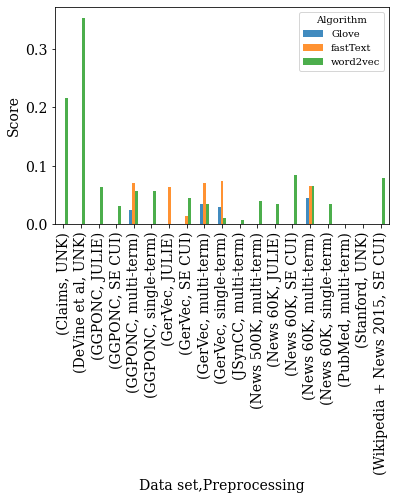

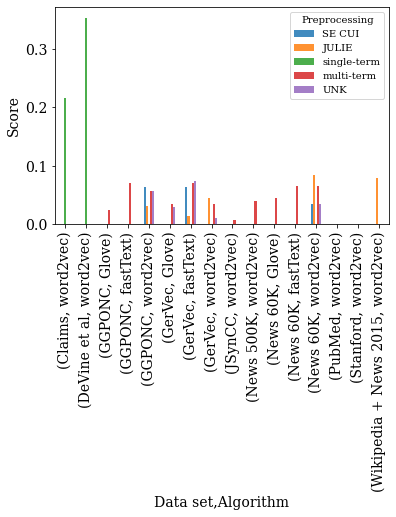

In [76]:
plot_single_benchmark(df, benchmark="HumanAssessment", grouping=["Data set", "Preprocessing", "Algorithm"], coloring="Algorithm", paper_mode=True)
plot_single_benchmark(df, benchmark="HumanAssessment", grouping=["Data set", "Algorithm"], coloring="Preprocessing", paper_mode=True)
# plot_single_benchmark(df, benchmark="CategoryBenchmark", grouping="Algorithm", coloring="Data set", paper_mode=False)

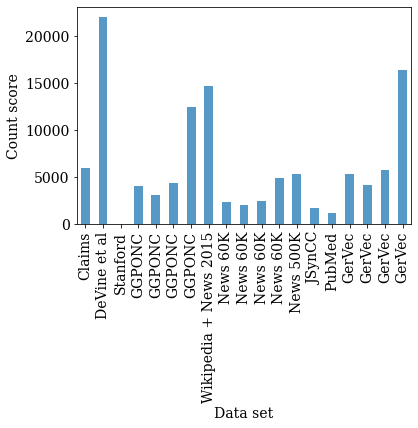

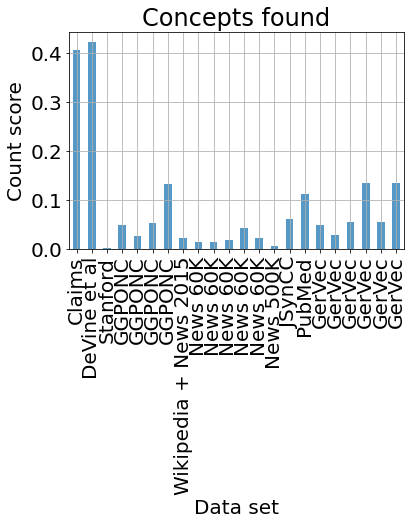

In [77]:
plot_counts(df, x_attribute="Data set", grouping ="", coloring=["# Concepts"], paper_mode=True)
plot_counts(df, x_attribute="Data set", grouping ="", coloring=["CUI Coverage"], paper_mode=False)